In [1]:
import sys
sys.path.insert(0, '..')

import torch
import os
import wandb
import random
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from ignite.handlers.param_scheduler import create_lr_scheduler_with_warmup
from torch.utils.data import DataLoader
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from tqdm import tqdm
from matplotlib import cm
import seaborn as sns
import matplotlib.lines as mlines
from sklearn.decomposition import PCA
from openTSNE import TSNE
from PIL import Image
import umap
import torch.nn.functional as F
from scipy.spatial.distance import cdist
import umap.plot
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
import random
import joblib

from core.final.dataset import PSMDataset
from core.final.model import GalSpecNet, MetaModel, Informer, AstroModel
from core.final.trainer import Trainer

/global/home/users/mariia/miniforge3/envs/astro/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
/global/home/users/mariia/miniforge3/envs/astro/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/global/home/users/mariia/miniforge3/envs/astro/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc 

In [4]:
def plot_one_embs(embeddings, targets):
    plt.figure(figsize=(10, 8))
    
    for class_name in sorted_classes:
        class_id = target2id[class_name]
        class_mask = targets == class_id
        plt.scatter(embeddings[class_mask, 0], embeddings[class_mask, 1], 
                    color=palette[class_id], label=class_name, alpha=1.0, s=marker_size)
        
    handles_colors = [mlines.Line2D([], [], color=palette[target2id[class_name]], marker='o', linestyle='None', markersize=8, 
                      label=class_name) for class_name in sorted_classes]
    plt.legend(handles=handles_colors, loc='upper right', bbox_to_anchor=(1.15, 1), fontsize=10, title="Classes")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

In [5]:
def get_embs(dataloader):
    all_p_emb, all_s_emb, all_m_emb = [], [], []
    all_labels = []
    
    for photometry, photometry_mask, spectra, metadata, labels in tqdm(dataloader):
        photometry, photometry_mask = photometry.to(device), photometry_mask.to(device)
        spectra, metadata = spectra.to(device), metadata.to(device)
    
        with torch.no_grad():
            p_emb, s_emb, m_emb = model.get_embeddings(photometry, photometry_mask, spectra, metadata)
    
            all_p_emb.append(p_emb.cpu())
            all_s_emb.append(s_emb.cpu())
            all_m_emb.append(m_emb.cpu())
            all_labels.append(labels)
    
    all_p_emb = torch.vstack(all_p_emb)
    all_s_emb = torch.vstack(all_s_emb)
    all_m_emb = torch.vstack(all_m_emb)
    all_labels = torch.hstack(all_labels)

    return all_p_emb, all_s_emb, all_m_emb, all_labels

In [14]:
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [111]:
run_id = 'MeriDK/AstroCLIPResults3/2wz4ysvn'
api = wandb.Api()
run = api.run(run_id)
config = run.config
config['use_wandb'] = False
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

model = AstroModel(config)
model = model.to(device)
model.eval()

weights_path = os.path.join(config['weights_path'] + '-' + run_id.split('/')[-1], f'weights-best.pth')
model.load_state_dict(torch.load(weights_path, weights_only=False))

<All keys matched successfully>

In [112]:
config['file'] = 'preprocessed_data/sub50_lb/spectra_and_v'

train_dataset = PSMDataset(config, split='train')
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=False)

test_dataset = PSMDataset(config, split='test')
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

In [117]:
class_freq = test_dataset.df['target'].value_counts()
sorted_classes = class_freq.index

id2target = test_dataset.id2target
target2id = test_dataset.target2id

palette = sns.color_palette("Spectral", len(id2target))
palette[3], palette[-4] = palette[-4], palette[3] 
palette[1], palette[-2] = palette[-2], palette[1] 
marker_size = 12

In [113]:
train_p_emb, train_s_emb, train_m_emb, train_labels = get_embs(train_dataloader)
test_p_emb, test_s_emb, test_m_emb, test_labels = get_embs(test_dataloader)

train_emb = (train_p_emb + train_s_emb + train_m_emb) / 3
test_emb = (test_p_emb + test_s_emb + test_m_emb) / 3

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:14<00:00,  4.98s/it]


In [115]:
umap = joblib.load('umap.pkl')
train_umap = umap.transform(train_emb)
test_umap = umap.transform(test_emb)

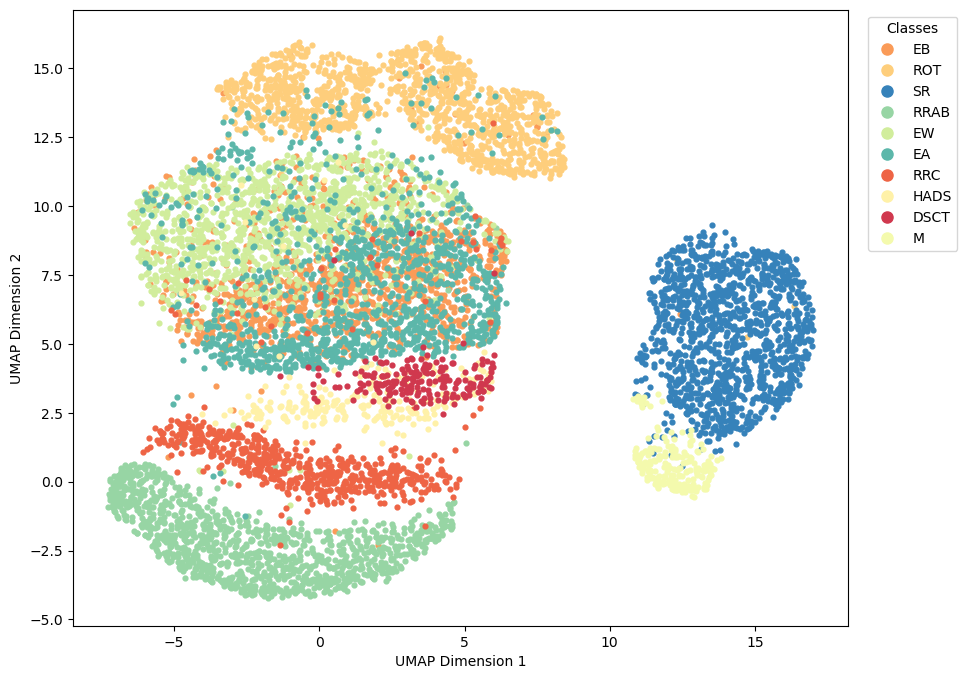

In [118]:
plot_one_embs(train_umap, train_labels)

In [ ]:
config['file'] = 'preprocessed_data/sub50_lb/spectra_and_v'
train_dataset = PSMDataset(config, split='train')
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=False)
photometry, photometry_mask, spectra, metadata, labels = next(iter(train_dataloader))

In [79]:
with torch.no_grad():
    p_emb, s_emb, m_emb = model.get_embeddings(photometry, photometry_mask, spectra, metadata)

In [80]:
with torch.no_grad():
    p_emb2, s_emb2, m_emb2 = model.get_embeddings(photometry, photometry_mask, spectra, metadata)

In [82]:
p_emb[0][0].item()

-0.014606318436563015

In [83]:
p_emb2[0][0].item()

-0.014605757780373096

In [107]:
with torch.no_grad():
    enc_out1 = model.photometry_encoder.enc_embedding(photometry)
    enc_out1, attns1 = model.photometry_encoder.encoder(enc_out1, attn_mask=None)
    # enc_out1 = model.photometry_encoder.dropout(enc_out1)

In [108]:
with torch.no_grad():
    enc_out2 = model.photometry_encoder.enc_embedding(photometry)
    enc_out2, attns2 = model.photometry_encoder.encoder(enc_out2, attn_mask=None)
    # enc_out2 = model.photometry_encoder.dropout(enc_out2)

In [109]:
enc_out1[0][0][0].item()

0.32919442653656006

In [110]:
enc_out2[0][0][0].item()

0.32919546961784363

In [22]:
config['file'] = 'preprocessed_data/sub50_lb/spectra_and_v'
train_dataset = PSMDataset(config, split='train')
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=False)

photometry, photometry_mask, spectra, metadata, labels = next(iter(train_dataloader))
# photometry, photometry_mask = photometry.to(device), photometry_mask.to(device)
# spectra, metadata = spectra.to(device), metadata.to(device)

with torch.no_grad():
    p_emb, s_emb, m_emb = model.get_embeddings(photometry, photometry_mask, spectra, metadata)

In [23]:
config['file'] = 'preprocessed_data/sub50_lb/spectra_and_v'
train_dataset = PSMDataset(config, split='train')
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=False)

photometry, photometry_mask, spectra, metadata, labels = next(iter(train_dataloader))
# photometry, photometry_mask = photometry.to(device), photometry_mask.to(device)
# spectra, metadata = spectra.to(device), metadata.to(device)

with torch.no_grad():
    p_emb2, s_emb2, m_emb2 = model.get_embeddings(photometry, photometry_mask, spectra, metadata)

In [25]:
p_emb[0][0].item(), p_emb2[0][0].item()

(-0.014605715870857239, -0.014606180600821972)

In [20]:
p_emb[0][0].item(), p_emb2[0][0].item()

(-0.014605816453695297, -0.01460631936788559)

In [35]:
train_dataset[0][0][0][1].item(), train_dataset[0][0][0][1].item()

(-0.13445916771888733, -0.13445916771888733)

In [36]:
train_dataset = PSMDataset(config, split='train')
train_dataset[0][0][0][1].item()

-0.13445916771888733

In [37]:
train_dataset = PSMDataset(config, split='train')
train_dataset[0][0][0][1].item()

-0.13445916771888733

In [38]:
photometry, photometry_mask, spectra, metadata, labels = train_dataset[0]

In [40]:
photometry

array([[ 0.        , -0.13445917,  0.20625566, ...,  1.1086379 ,
         0.34360552,  5.0494432 ],
       [ 0.12272438,  1.6801374 ,  0.23980054, ...,  1.1086379 ,
         0.34360552,  5.0494432 ],
       [ 0.12327029, -2.0755289 ,  0.19174977, ...,  1.1086379 ,
         0.34360552,  5.0494432 ],
       ...,
       [ 0.9803993 , -1.8543141 ,  0.19718948, ...,  1.1086379 ,
         0.34360552,  5.0494432 ],
       [ 0.980974  ,  0.8333559 ,  0.22438803, ...,  1.1086379 ,
         0.34360552,  5.0494432 ],
       [ 0.9815421 ,  0.5187593 ,  0.21849501, ...,  1.1086379 ,
         0.34360552,  5.0494432 ]], dtype=float32)

In [48]:
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=False)
photometry, photometry_mask, spectra, metadata, labels = next(iter(train_dataloader))

In [49]:
photometry[0][0][1].item()

-0.13445916771888733

In [50]:
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=False)
photometry2, photometry_mask2, spectra2, metadata2, labels2 = next(iter(train_dataloader))

In [51]:
photometry2[0][0][1].item()

-0.13445916771888733

In [65]:
with torch.no_grad():
    p_emb, s_emb, m_emb = model.get_embeddings(photometry, photometry_mask, spectra, metadata)

In [67]:
p_emb[0][0].item(), s_emb[0][0].item(), m_emb[0][0].item()

(-0.014605403877794743, -0.004278720356523991, 0.01774914748966694)

In [68]:
with torch.no_grad():
    p_emb2, s_emb2, m_emb2 = model.get_embeddings(photometry, photometry_mask, spectra, metadata)

In [69]:
p_emb2[0][0].item(), s_emb2[0][0].item(), m_emb2[0][0].item()

(-0.014605673030018806, -0.004278720356523991, 0.01774914748966694)

In [59]:
p_emb = model.photometry_proj(model.photometry_encoder(photometry, photometry_mask))
p_emb2 = model.photometry_proj(model.photometry_encoder(photometry, photometry_mask))

In [60]:
p_emb[0][0].item()

-0.8401257991790771

In [61]:
p_emb2[0][0].item()

-0.8400710821151733

In [62]:
p_emb = model.photometry_encoder(photometry, photometry_mask)
p_emb2 = model.photometry_encoder(photometry, photometry_mask)

In [63]:
p_emb[0][0].item()

0.32919520139694214

In [64]:
p_emb2[0][0].item()

0.3291948735713959

In [8]:
config['file'] = 'preprocessed_data/sub50_lb/spectra_and_v'
test_dataset = PSMDataset(config, split='test')
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

train_dataset = PSMDataset(config, split='train')
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=False)

class_freq = test_dataset.df['target'].value_counts()
sorted_classes = class_freq.index

id2target = test_dataset.id2target
target2id = test_dataset.target2id

palette = sns.color_palette("Spectral", len(id2target))
palette[3], palette[-4] = palette[-4], palette[3] 
palette[1], palette[-2] = palette[-2], palette[1] 
# palette = sns.color_palette("tab20", len(id2target))
marker_size = 12

In [10]:
photometry, photometry_mask, spectra, metadata, labels = next(iter(train_dataloader))
photometry, photometry_mask = photometry.to(device), photometry_mask.to(device)
spectra, metadata = spectra.to(device), metadata.to(device)

with torch.no_grad():
    p_emb, s_emb, m_emb = model.get_embeddings(photometry, photometry_mask, spectra, metadata)

In [13]:
p_emb[0][0].item(), p_emb2[0][0].item()

(-0.014605816453695297, -0.01460631936788559)

In [71]:
weights = torch.load(weights_path, weights_only=False)

In [77]:
weights['photometry_encoder.enc_embedding.value_embedding.tokenConv.weight'].dtype == torch.float32

True

In [78]:
for key, value in weights.items():
    if value.dtype != torch.float32:
        print(f"Weight: {key}, dtype: {value.dtype}")

In [51]:
train_p_emb, train_s_emb, train_m_emb, train_labels = get_embs(train_dataloader)
# test_p_emb, test_s_emb, test_m_emb, test_labels = get_embs(test_dataloader)

 82%|███████████████████████████████████████████████████████████████████▌              | 14/17 [01:33<00:20,  6.67s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 200.00 MiB. GPU 1 has a total capacity of 10.90 GiB of which 199.31 MiB is free. Process 967922 has 2.01 GiB memory in use. Process 3503018 has 1.84 GiB memory in use. Process 3930117 has 2.06 GiB memory in use. Process 55402 has 1.84 GiB memory in use. Process 171818 has 1.84 GiB memory in use. Including non-PyTorch memory, this process has 1.12 GiB memory in use. Of the allocated memory 533.08 MiB is allocated by PyTorch, and 448.92 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
train_emb = (train_p_emb + train_s_emb + train_m_emb) / 3
# test_emb = (test_p_emb + test_s_emb + test_m_emb) / 3

In [ ]:
train_p_emb2, train_s_emb2, train_m_emb2, train_labels2 = get_embs(train_dataloader)

In [ ]:
train_emb2 = (train_p_emb2 + train_s_emb2 + train_m_emb2) / 3

In [ ]:
train_emb2[0][0].item(), train_emb[0][0].item()

In [ ]:
train_p_emb2[0][0].item(), train_p_emb[0][0].item()

In [57]:
a = torch.tensor(0.0003784261643886566, device='cuda')
b = torch.tensor(0.0003784261643886566, device='cuda')

In [61]:
a.item() == b.item()

True

In [65]:
a.cpu().item() == b.cpu().item()

True

In [60]:
b.item()

0.0003784261643886566

In [55]:
a

tensor(0.0004)

In [35]:
train_emb[0][0].item()

-0.0003784261643886566

In [32]:
train_emb[0][0].item()

-0.00037845844053663313

In [39]:
train_m_emb[0][0].item() == train_m_emb[0][0].item()

True

In [40]:
train_s_emb[0][0].item() == train_s_emb[0][0].item()

True

In [41]:
train_p_emb[0][0].item() == train_p_emb[0][0].item()

True

In [43]:
((train_m_emb + train_s_emb + train_p_emb) / 3)[0][0].item() == ((train_m_emb + train_s_emb + train_p_emb) / 3)[0][0].item()

True

In [9]:
# joblib.dump(train_emb, 'train_emb1.pkl')
train_emb_prev = joblib.load('train_emb1.pkl')

/global/home/users/mariia/miniforge3/envs/astro/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO

In [10]:
train_emb

tensor([[-0.0004,  0.0029, -0.0007,  ..., -0.0062,  0.0074, -0.0015],
        [-0.0008, -0.0035,  0.0087,  ...,  0.0028, -0.0040, -0.0114],
        [-0.0115, -0.0070, -0.0070,  ..., -0.0307,  0.0024,  0.0007],
        ...,
        [ 0.0191, -0.0099,  0.0041,  ...,  0.0164, -0.0079,  0.0030],
        [-0.0129,  0.0025,  0.0046,  ..., -0.0277, -0.0082,  0.0124],
        [ 0.0033,  0.0050,  0.0027,  ...,  0.0126, -0.0051,  0.0021]])

In [14]:
train_emb_prev

tensor([[-0.0004,  0.0029, -0.0007,  ..., -0.0062,  0.0074, -0.0015],
        [-0.0008, -0.0035,  0.0087,  ...,  0.0028, -0.0040, -0.0114],
        [-0.0115, -0.0070, -0.0071,  ..., -0.0307,  0.0024,  0.0007],
        ...,
        [ 0.0191, -0.0099,  0.0041,  ...,  0.0164, -0.0079,  0.0030],
        [-0.0130,  0.0025,  0.0046,  ..., -0.0277, -0.0082,  0.0123],
        [ 0.0033,  0.0050,  0.0027,  ...,  0.0126, -0.0051,  0.0021]])

In [17]:
train_emb_prev[0][0], train_emb[0][0]

(tensor(-0.0004), tensor(-0.0004))

In [18]:
torch.equal(train_emb_prev[0][0], train_emb[0][0])

False

In [22]:
train_emb_prev[0][0].item()

-0.00037883842014707625

In [23]:
train_emb[0][0].item()

-0.00037837462150491774

In [24]:
len(train_labels), len(train_dataset)

(8526, 8526)

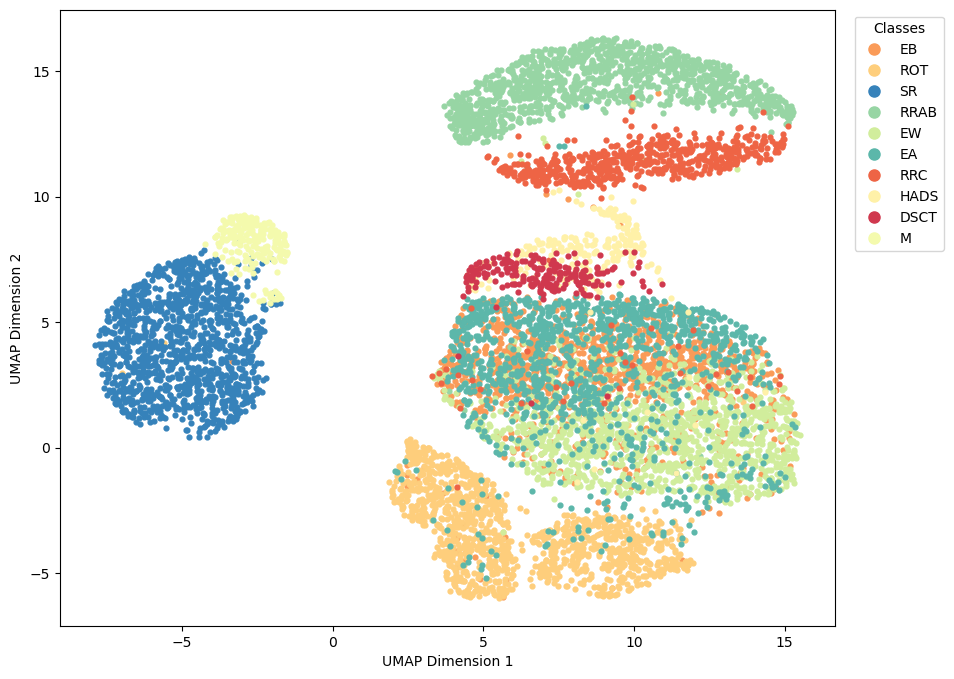

In [9]:
train_emb = (train_p_emb + train_s_emb + train_m_emb) / 3
test_emb = (test_p_emb + test_s_emb + test_m_emb) / 3

umap_model = umap.UMAP(n_neighbors=45, min_dist=0.7, n_components=2, metric='cosine', n_jobs=1, random_state=42)
trans = umap_model.fit(train_emb)

train_umap = trans.transform(train_emb)
test_umap = trans.transform(test_emb)

plot_one_embs(train_umap, train_labels)

In [10]:
train_emb = (train_p_emb + train_s_emb + train_m_emb) / 3
test_emb = (test_p_emb + test_s_emb + test_m_emb) / 3

umap_model = umap.UMAP(n_neighbors=45, min_dist=0.7, n_components=2, metric='cosine', n_jobs=1, random_state=42, force_approximation_algorithm=False)
trans = umap_model.fit(train_emb)

train_umap = trans.transform(train_emb)
test_umap = trans.transform(test_emb)

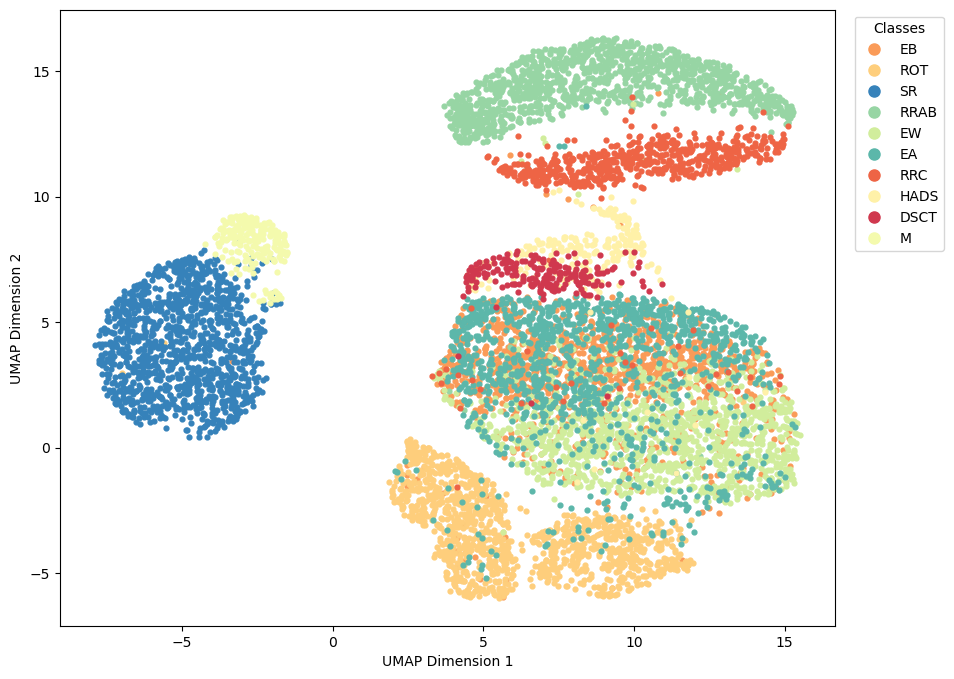

In [11]:
plot_one_embs(train_umap, train_labels)

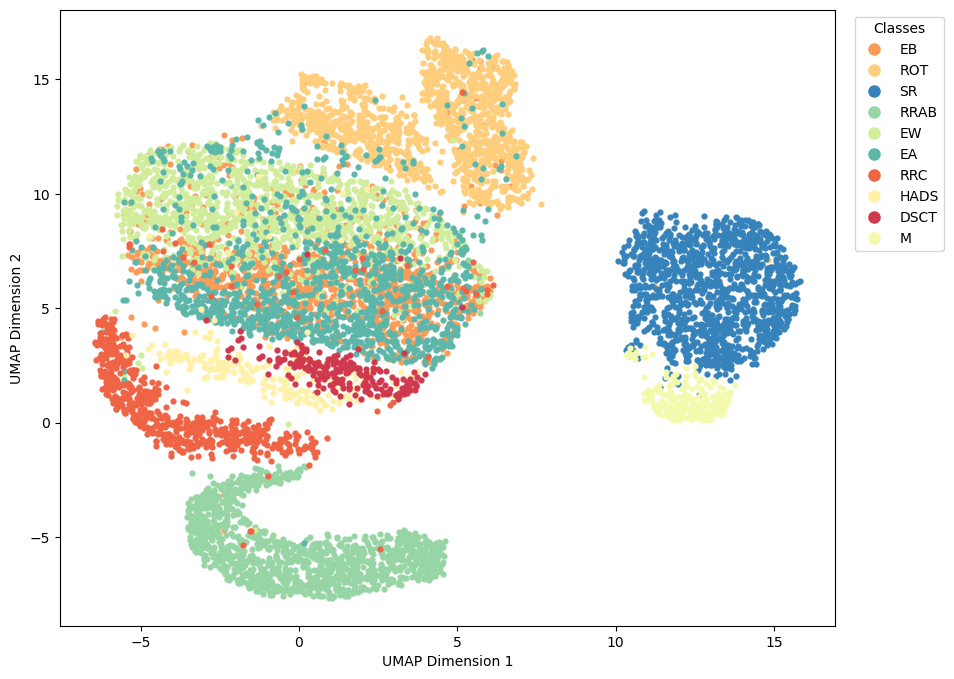

In [9]:
plot_one_embs(train_umap, train_labels)

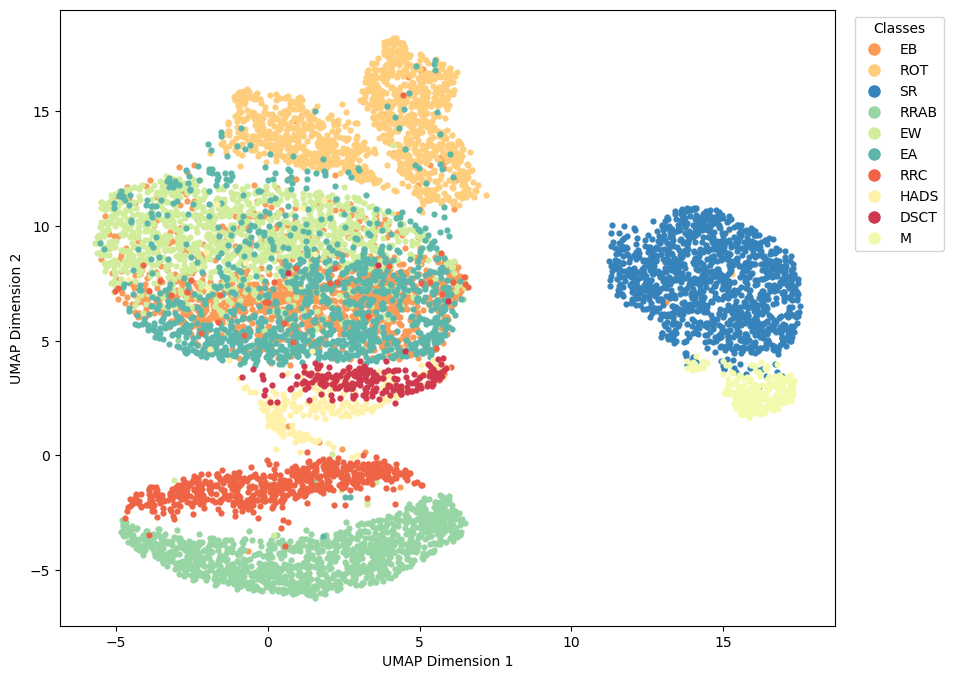

In [8]:
train_emb = (train_p_emb + train_s_emb + train_m_emb) / 3
test_emb = (test_p_emb + test_s_emb + test_m_emb) / 3

umap_model = umap.UMAP(n_neighbors=45, min_dist=0.7, n_components=2, metric='cosine', n_jobs=1, random_state=42)
trans = umap_model.fit(train_emb)

train_umap = trans.transform(train_emb)
test_umap = trans.transform(test_emb)

plot_one_embs(train_umap, train_labels)

In [10]:
idx = 0

el = test_dataset.df.iloc[idx]
label = target2id[el['target']]
period = el['org_period']

photometry = test_dataset.get_vlc(el['name'])
spectra = test_dataset.readLRSFits(os.path.join(test_dataset.lamost_spec_dir, el['spec_filename']))
metadata = el[test_dataset.meta_cols].values.astype(np.float32)

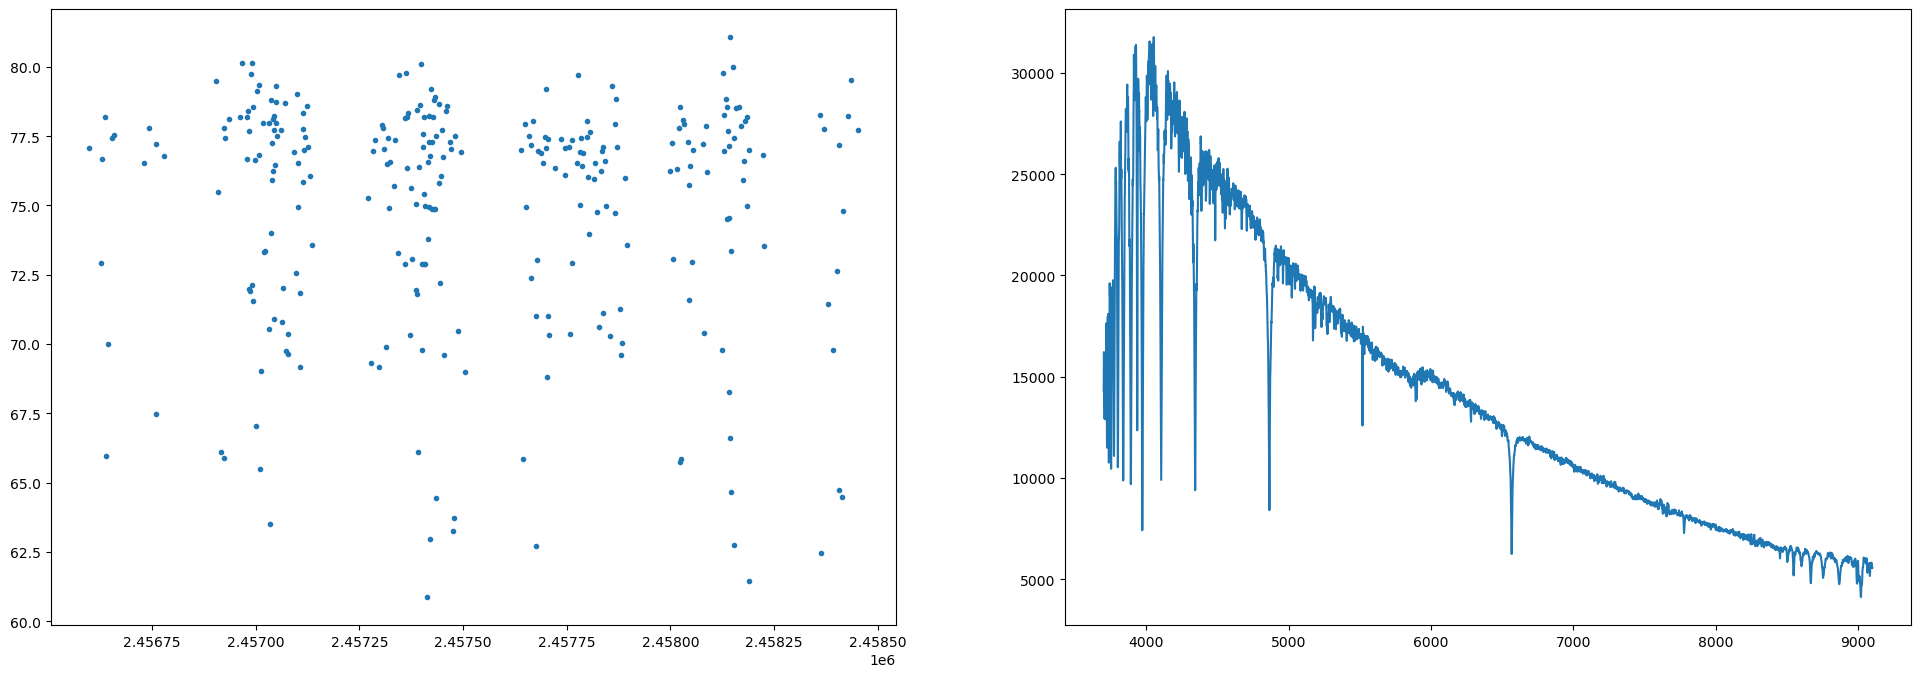

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(24, 8))
axs[0].plot(photometry[:, 0], photometry[:, 1], '.', label='Photometry')
axs[1].plot(spectra[:, 0], spectra[:, 1], label='Spectra')